## 2023 Open Science Data Challenge - Sentinel-1 Phenology

This notebook calculates vegetation phenology changes using radiometrically terrain corrected Sentinel-1 radar data. To detect vegetation changes, the algorithm uses variations in the Radar Vegetation Index (RVI) which is a common proxy for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting. The baseline data is [Sentinel-1 RTC](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) data from the MS Planetary Computer catalog. For more information about how to interpret radar data, see the following document: "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.


In [14]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio.features
import pandas as pd

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer as pc
import xrspatial.multispectral as ms
import odc
from odc.stac import stac_load

from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Pass your API key here
pc.settings.set_subscription_key('3e8a506cfd874a6d975fe84405d94f6b')

In [1]:
def get_rvi_new(latlong):
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    box_size_deg = 0.0004 
    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2
    bbox = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = "2021-12-01/2022-04-30"
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest)
    items = list(search.get_all_items()) 
    resolution = 10  
    scale = resolution / 111320.0 
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, crs="EPSG:4326", resolution=scale)
    mean = data.mean(dim=['latitude','longitude']).compute()
    return mean.vv.values.tolist(), mean.vh.values.tolist()


In [ ]:
import pandas as pd
labelled = pd.read_csv("Crop_Location_Data.csv")
labelled[['vv', 'vh']] = labelled.apply(lambda row : get_rvi_new(row['Latitude and Longitude']), axis = 1).apply(pd.Series)


In [ ]:
labelled['vvlen'] = labelled['vv'].apply(len)
labelled['vhlen'] = labelled['vh'].apply(len)

In [ ]:
labelled[labelled['vhlen'] !=27]

In [ ]:
labelled[[f'vv_{i+1}' for i in range(27)]] = labelled['vv'].apply(lambda x: pd.Series(x))
labelled[[f'vh_{i+1}' for i in range(27)]] = labelled['vv'].apply(lambda x: pd.Series(x))

In [ ]:
labelled['Class of Land'] = labelled['Class of Land'].replace({'Rice': 1, 'Non Rice': 0})

In [4]:
def compute_rvi(dataframe):
    vv_columns = [col for col in dataframe.columns if col.startswith('vv_')]
    vh_columns = [col for col in dataframe.columns if col.startswith('vh_')]
    rvi_values = pd.DataFrame()
    for i, vv_col in enumerate(vv_columns):
        vh_col = vh_columns[i]
        rvi_col = f'rvi_{i+1}'
        
        dop = dataframe[vv_col] / (dataframe[vv_col] + dataframe[vh_col])
        rvi_values[rvi_col] = (np.sqrt(dop))*((4*dataframe[vh_col])/(dataframe[vv_col] + dataframe[vh_col]))
    
    return rvi_values
labelled = labelled.merge(compute_rvi(labelled),left_index=True, right_index=True)
labelled

,Latitude and Longitude,Class of Land,vv,vh,vv_1,vv_2,vv_3,vv_4,vv_5,vv_6,...,rvi_18,rvi_19,rvi_20,rvi_21,rvi_22,rvi_23,rvi_24,rvi_25,rvi_26,rvi_27
0,"(10.323727047081501, 105.2516346045924)",1,"[0.16120508313179016, 0.204640194773674, 0.107...","[0.08404920995235443, 0.04176129773259163, 0.0...",0.161205,0.204640,0.107861,0.028466,0.027198,0.074212,...,0.902072,1.171599,0.838371,0.943192,0.914085,0.720200,0.392779,0.476010,0.103610,0.143693
1,"(10.322364360592521, 105.27843410554115)",1,"[0.09824228286743164, 0.06113070622086525, 0.0...","[0.021684356033802032, 0.017600685358047485, 0...",0.098242,0.061131,0.025031,0.081901,0.084918,0.013014,...,0.501215,0.937816,0.837070,0.585188,0.452534,0.514370,0.649338,0.821845,0.128328,0.205585
2,"(10.321455902933202, 105.25254306225168)",1,"[0.21969293057918549, 0.1161704808473587, 0.15...","[0.07655175030231476, 0.038844820111989975, 0....",0.219693,0.116170,0.158129,0.033497,0.076157,0.112318,...,0.943754,1.275416,1.046369,0.959884,0.760175,0.812749,0.348851,0.835256,0.117263,0.241471
3,"(10.324181275911162, 105.25118037576274)",1,"[0.24752603471279144, 0.19171142578125, 0.1725...","[0.05276329442858696, 0.04652192071080208, 0.0...",0.247526,0.191711,0.172536,0.053028,0.063874,0.044373,...,1.057294,0.856103,0.976609,1.033484,0.813460,0.626310,0.286811,0.369860,0.139756,0.135464
4,"(10.324635504740822, 105.27389181724476)",1,"[0.02874036878347397, 0.034981049597263336, 0....","[0.008084205910563469, 0.008058927021920681, 0...",0.028740,0.034981,0.028032,0.086748,0.082367,0.048865,...,0.924986,0.927852,1.024063,0.894529,0.970199,0.781271,0.336018,0.363929,0.129689,0.160615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",0,"[0.5538221001625061, 0.23980477452278137, 0.49...","[0.11963021755218506, 0.05086619034409523, 0.0...",0.553822,0.239805,0.497007,0.502335,0.238016,0.216650,...,0.742173,0.826487,0.642782,0.787197,0.633410,0.656763,0.860632,0.655824,0.601107,0.749359
596,"(10.01348875642372, 105.67361318732796)",0,"[0.4096662700176239, 0.18713922798633575, 0.39...","[0.06944955885410309, 0.07818399369716644, 0.1...",0.409666,0.187139,0.398297,0.338420,0.299714,0.274721,...,0.744398,0.955176,0.862822,0.790569,0.866503,0.681354,0.834037,1.040018,0.745269,0.737065
597,"(10.013034527594062, 105.67361318732796)",0,"[0.3816567063331604, 0.2316872775554657, 0.281...","[0.06367096304893494, 0.04903304949402809, 0.0...",0.381657,0.231687,0.281397,0.229825,0.296210,0.296155,...,0.696490,0.733263,0.763661,0.739260,0.761265,0.553799,0.634686,0.787183,0.699356,0.700492
598,"(10.012580298764401, 105.67361318732796)",0,"[0.3778179883956909, 0.23963706195354462, 0.39...","[0.08155189454555511, 0.06660118699073792, 0.0...",0.377818,0.239637,0.392120,0.337675,0.336124,0.259110,...,0.480712,0.716867,0.765631,0.683218,0.714224,0.773886,0.793619,0.622315,0.817134,0.775506


In [5]:
labelled.to_csv("labelfinal.csv")

In [ ]:
#load the test/train locations with labels 

In [6]:
import pandas as pd
labelled = pd.read_csv("labelfinal.csv",index_col=0)

In [ ]:
#load the coordinates we need to classify

In [30]:
#challengevvvh is a dataset with vv,vh,and rvi values for the coordinates
#that need to be predicted
#the functions described above were applied to the coordinates
#before being introduced in here
traintest = pd.read_csv("challengevvvh.csv",index_col=0)
rvi_test = traintest.iloc[:,54:]
vvvh_test = traintest.iloc[:,0:54]

In [45]:
vvvh_test

,vv_1,vv_2,vv_3,vv_4,vv_5,vv_6,vv_7,vv_8,vv_9,vv_10,...,vh_18,vh_19,vh_20,vh_21,vh_22,vh_23,vh_24,vh_25,vh_26,vh_27
0,0.008987,0.007270,0.012203,0.057780,0.062333,0.088580,0.081579,0.051167,0.250028,0.174388,...,0.022101,0.017389,0.060436,0.062894,0.016909,0.010678,0.020193,0.006644,0.034006,0.009960
1,0.007967,0.036262,0.007039,0.017165,0.024918,0.033908,0.039307,0.023896,0.219948,0.176648,...,0.020317,0.029668,0.049618,0.049646,0.036581,0.058695,0.010209,0.013636,0.004598,0.010888
2,0.029800,0.053016,0.024547,0.088521,0.129876,0.025643,0.184278,0.213048,0.182058,0.260868,...,0.030566,0.045878,0.062396,0.081252,0.031483,0.032502,0.030799,0.028669,0.010847,0.023678
3,0.014225,0.015645,0.011348,0.011752,0.011472,0.011265,0.010076,0.010482,0.017806,0.012019,...,0.004184,0.004396,0.004145,0.004635,0.003280,0.005152,0.005172,0.006122,0.004526,0.004711
4,0.060342,0.053864,0.055162,0.154720,0.157120,0.266355,0.186890,0.253313,0.058508,0.038998,...,0.038631,0.046441,0.011593,0.027450,0.015216,0.015021,0.007324,0.007211,0.025045,0.021041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.020300,0.666354,0.015807,0.025564,0.015455,0.012502,0.010451,0.010755,0.013717,0.010535,...,0.005093,0.004361,0.005915,0.004112,0.005967,0.004481,0.006311,0.005117,0.005124,0.004446
246,0.008782,0.017660,0.013875,0.009660,0.014397,0.011821,0.012415,0.007456,0.011482,0.009316,...,0.004179,0.005264,0.004965,0.006442,0.004920,0.002797,0.003958,0.005613,0.004041,0.004782
247,0.013371,0.018271,0.010270,0.012861,0.009466,0.008647,0.010109,0.010986,0.013803,0.011336,...,0.003723,0.004223,0.009707,0.015919,0.004750,0.004600,0.005089,0.004233,0.003111,0.004285
248,0.057001,0.068757,0.042387,0.108638,0.178153,0.008917,0.259858,0.229220,0.232518,0.206621,...,0.027527,0.033299,0.069413,0.053736,0.025508,0.031941,0.004132,0.006957,0.004651,0.007945


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=   2.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   3.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=False, max_dept

In [8]:
#CNN model with rvi values 

In [61]:

# Get the data
X = labelled.iloc[:, 58:]
y = labelled['Class of Land']

# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Scale the data
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Reshape the data to be compatible with 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the model
model_cnn_ov = Sequential()
model_cnn_ov.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model_cnn_ov.add(Dropout(0.2))
model_cnn_ov.add(Conv1D(64, kernel_size=3, activation='relu'))
model_cnn_ov.add(MaxPooling1D(pool_size=2))
model_cnn_ov.add(Conv1D(128, kernel_size=3, activation='relu'))
model_cnn_ov.add(MaxPooling1D(pool_size=2))
model_cnn_ov.add(Flatten())
model_cnn_ov.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_ov.add(Dropout(0.5))
model_cnn_ov.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_ov.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model_cnn_ov.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
score = model_cnn_ov.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
12/12 [==============================] - 2s 28ms/step - loss: 1.2102 - accuracy: 0.5500 - val_loss: 1.1094 - val_accuracy: 0.8750
Epoch 2/100
12/12 [==============================] - 0s 10ms/step - loss: 1.0365 - accuracy: 0.6694 - val_loss: 0.9449 - val_accuracy: 0.9667
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.8762 - accuracy: 0.7889 - val_loss: 0.7566 - val_accuracy: 0.9750
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 0.6743 - accuracy: 0.8472 - val_loss: 0.5249 - val_accuracy: 0.9500
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.4836 - accuracy: 0.9083 - val_loss: 0.3549 - val_accuracy: 0.9750
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3622 - accuracy: 0.9083 - val_loss: 0.2599 - val_accuracy: 0.9833
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 0.2979 - accuracy: 0.9306 - val_loss: 0.2332 - val_accuracy: 0.9833
Epoch 

In [67]:
# Make predictions on the test set
y_pred = model_cnn_ov.predict(rvi_test)
# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)
result = y_pred_binary.flatten()
result = pd.Series(result)

8/8 [==============================] - 0s 3ms/step


In [68]:
pred = model_cnn_ov.predict(X_test)
pred_binary = (pred>0.5).astype(int)


4/4 [==============================] - 0s 3ms/step


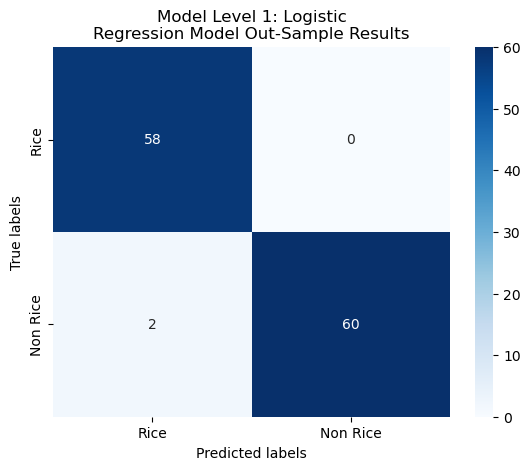

In [69]:
plot_confusion_matrix(y_test,pred_binary,"Model Level 1: CNN model with RVI values",['Rice', 'Non Rice'])

In [ ]:
#CNN model with vv and vh values 

In [70]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Get the data
X = labelled.iloc[:, 4:58]
y = labelled['Class of Land']

# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Scale the data
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Reshape the data to be compatible with 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the model
model_cnn_ov_vv = Sequential()
model_cnn_ov_vv.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model_cnn_ov_vv.add(Dropout(0.2))
model_cnn_ov_vv.add(Conv1D(64, kernel_size=3, activation='relu'))
model_cnn_ov_vv.add(MaxPooling1D(pool_size=2))
model_cnn_ov_vv.add(Conv1D(128, kernel_size=3, activation='relu'))
model_cnn_ov_vv.add(MaxPooling1D(pool_size=2))
model_cnn_ov_vv.add(Flatten())
model_cnn_ov_vv.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_ov_vv.add(Dropout(0.5))
model_cnn_ov_vv.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_ov_vv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model_cnn_ov_vv.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
score = model_cnn_ov_vv.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
12/12 [==============================] - 3s 52ms/step - loss: 1.1906 - accuracy: 0.5528 - val_loss: 1.0244 - val_accuracy: 0.5917
Epoch 2/100
12/12 [==============================] - 0s 19ms/step - loss: 0.9385 - accuracy: 0.6056 - val_loss: 0.7907 - val_accuracy: 0.8917
Epoch 3/100
12/12 [==============================] - 0s 20ms/step - loss: 0.7633 - accuracy: 0.6917 - val_loss: 0.5632 - val_accuracy: 0.9250
Epoch 4/100
12/12 [==============================] - 0s 25ms/step - loss: 0.5790 - accuracy: 0.7750 - val_loss: 0.3776 - val_accuracy: 0.9417
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 0.4228 - accuracy: 0.9167 - val_loss: 0.2554 - val_accuracy: 0.9917
Epoch 6/100
12/12 [==============================] - 0s 22ms/step - loss: 0.2988 - accuracy: 0.9583 - val_loss: 0.2313 - val_accuracy: 0.9583
Epoch 7/100
12/12 [==============================] - 0s 26ms/step - loss: 0.2315 - accuracy: 0.9667 - val_loss: 0.1381 - val_accuracy: 1.0000
Epoch 

In [71]:
# Make predictions on the test set
y_pred_vvvh = model_cnn_ov_vv.predict(vvvh_test)
# Convert predicted probabilities to binary predictions
y_pred_binary_vvvh = (y_pred_vvvh > 0.5).astype(int)
result_vvvh = y_pred_binary.flatten()
result_vvvh = pd.Series(result)

8/8 [==============================] - 0s 3ms/step


In [72]:
pred = model_cnn_ov_vv.predict(X_test)
pred_binary = (pred>0.5).astype(int)

4/4 [==============================] - 0s 3ms/step


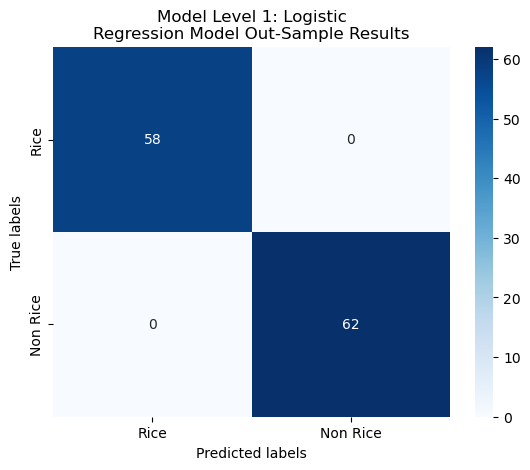

In [73]:
plot_confusion_matrix(y_test,pred_binary,"Model Level 1: CNN model with VV&VH values",['Rice', 'Non Rice'])

In [ ]:
#Logistic regression with rvi values 

In [74]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler


X = labelled.iloc[:, 58:]
y = labelled['Class of Land']

# Splitting the dataset into train, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Scale the data
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Define and fit the logistic regression model
clf_rvi = LogisticRegression(random_state=42, max_iter=1000)
clf_rvi.fit(X_train, y_train)

# Evaluate the model on the validation set
val_score = clf_rvi.score(X_val, y_val)
print('Validation accuracy:', val_score)

# Perform cross-validation on the training set
cv_scores = cross_val_score(clf_rvi, X_train, y_train, cv=5)
print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())

# Evaluate the model on the test set
test_score = clf_rvi.score(X_test, y_test)
print('Test accuracy:', test_score)

Validation accuracy: 0.9666666666666667
Cross-validation scores: [0.95833333 0.95833333 0.97222222 1.         0.97222222]
Average cross-validation score: 0.9722222222222221
Test accuracy: 0.95


In [75]:
pred_minmax_rvi = pd.Series(clf_rvi.predict(rvi_test))
pred_minmax_rvi.value_counts()

0    190
1     60
dtype: int64

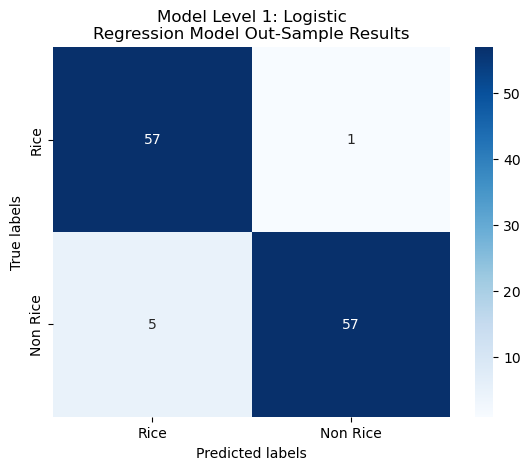

In [76]:
plot_confusion_matrix(y_test,clf_rvi.predict(X_test),"Model Level 1: Logistic\nRegression Model with RVI values",['Rice', 'Non Rice'])

In [ ]:
#Logistic regression with vvvh values 

In [77]:
X = labelled.iloc[:, 4:58]
y = labelled['Class of Land']

# Splitting the dataset into train, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Scale the data
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Define and fit the logistic regression model
clf_vvvh = LogisticRegression(random_state=42, max_iter=1000)
clf_vvvh.fit(X_train, y_train)

# Evaluate the model on the validation set
val_score = clf_vvvh.score(X_val, y_val)
print('Validation accuracy:', val_score)

# Perform cross-validation on the training set
cv_scores = cross_val_score(clf_vvvh, X_train, y_train, cv=5)
print('Cross-validation scores:', cv_scores)
print('Average cross-validation score:', cv_scores.mean())

# Evaluate the model on the test set
test_score = clf_vvvh.score(X_test, y_test)
print('Test accuracy:', test_score)

Validation accuracy: 0.975
Cross-validation scores: [0.98611111 0.95833333 0.93055556 1.         0.97222222]
Average cross-validation score: 0.9694444444444444
Test accuracy: 0.9666666666666667


In [78]:
pred_minmax_vvvh = pd.Series(clf_vvvh.predict(vvvh_test))
pred_minmax_vvvh.value_counts()

0    158
1     92
dtype: int64

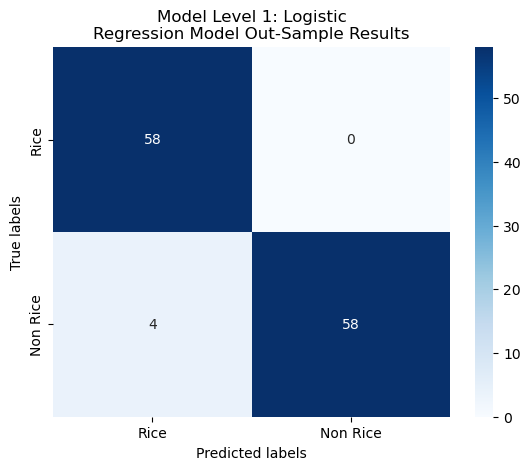

In [79]:
plot_confusion_matrix(y_test,clf_vvvh.predict(X_test),"Model Level 1: Logistic\nRegression Model with VV&VH values",['Rice', 'Non Rice'])

In [ ]:
#Random Forest with rvi values 

In [80]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Get the data
X = labelled.iloc[:, 58:]
y = labelled['Class of Land']

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier()

clf_random_rvi = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf_random_rvi.fit(X_train, y_train)

print("Best score on the training set")
print(clf_random_rvi.best_score_)
print("Actual score on the testing set")
metrics.accuracy_score(y_test,clf_random_rvi.predict(X_test))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

Best score on the training set
0.9979166666666667
Actual score on the testing set


0.9833333333333333

In [81]:
result_rf_rvi = clf_random_rvi.predict(rvi_test)
result_rf_rvi = pd.Series(result_rf_rvi)

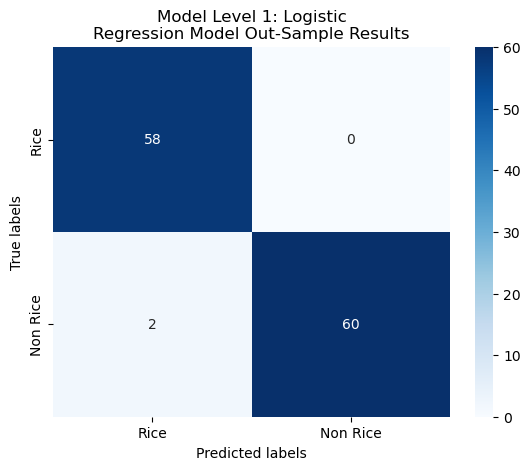

In [82]:
plot_confusion_matrix(y_test,clf_random_rvi.predict(X_test),"Model Level 1:Random forest with RVI values",['Rice', 'Non Rice'])

In [ ]:
#Random Forest with vvvh values 

In [83]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Get the data
X = labelled.iloc[:, 4:58]
y = labelled['Class of Land']

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier()

clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf_random.fit(X_train, y_train)

print("Best score on the training set")
print(clf_random.best_score_)
print("Actual score on the testing set")
metrics.accuracy_score(y_test,clf_random.predict(X_test))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

Best score on the training set
0.9979166666666667
Actual score on the testing set


0.9916666666666667

In [84]:
result_rf = clf_random.predict(vvvh_test)
result_rf = pd.Series(result_rf)

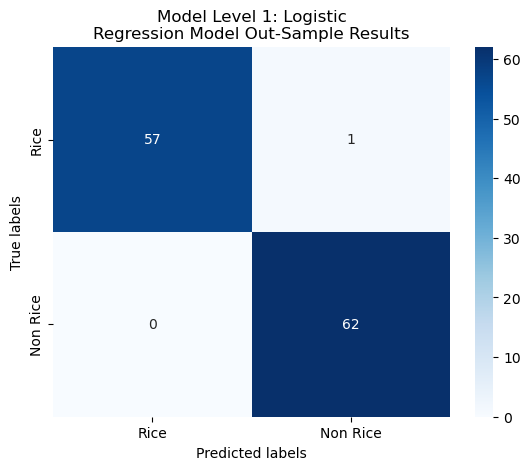

In [85]:
plot_confusion_matrix(y_test,clf_random.predict(X_test),"Model Level 1:Random forest with VV&VH values",['Rice', 'Non Rice'])

In [ ]:
#comparison of all models generated 

In [86]:
print("CNN with rvi values")
print(result.value_counts())
print("CNN with vvvh values")
print(result_vvvh.value_counts())

print("Logistic regression with rvi values")
print(pred_minmax_rvi.value_counts())
print("Logistic regression with vvvh values")
print(pred_minmax_vvvh.value_counts())

print("Random Forest with rvi values")
print(result_rf_rvi.value_counts())
print("Random Forest with vvvh values")
print(result_rf.value_counts())

CNN with rvi values
0    179
1     71
dtype: int64
CNN with vvvh values
0    179
1     71
dtype: int64
Logistic regression with rvi values
0    190
1     60
dtype: int64
Logistic regression with vvvh values
0    158
1     92
dtype: int64
Random Forest with rvi values
0    174
1     76
dtype: int64
Random Forest with vvvh values
0    214
1     36
dtype: int64
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   1.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   2.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_sample

In [ ]:
#choosing the appropriate model

In [ ]:
#confusion matrix

In [55]:
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

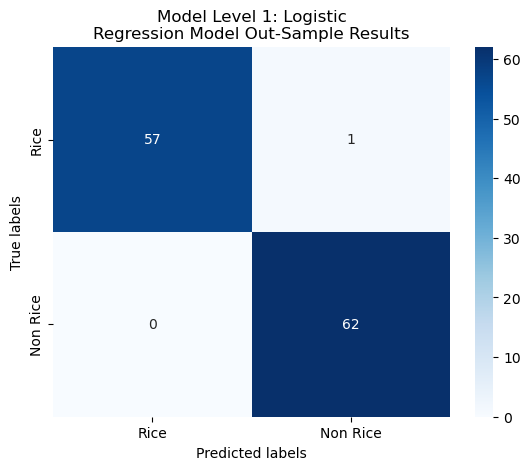

In [58]:
plot_confusion_matrix(y_test,clf_random.predict(X_test),"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

In [105]:
resultdf = pd.DataFrame(result_rf_rvi)
resultdf.columns = ['Class of Land']

In [106]:
submission = pd.read_csv("challenge_1_submission_template_correct_columns_fixed.csv")

In [107]:
submission

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [108]:
submission = submission.merge(resultdf,left_index=True, right_index=True)
submission['Class of Land'] = submission['Class of Land'].replace({1:'Rice', 0:'Non Rice'})
submission= submission.drop(columns = 'target',axis=1)
submission.columns = ['id','target']
submission.to_csv('challenge_1_submission_template_correct_columns_fixed1.csv',index=False)

In [104]:
submission

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice
